Тематическое моделирование

Цель исследования - рассмотреть интересные аудитории пабликов, увидеть их сходство и различие интересов. В качестве темы мы выбрали политику. Рассмотрим аудитории двух разных политических сил.

1)Первая политическая сила:
    Паблик Путин Тим (https://vk.com/putinteam),
    Паблик Единой России (https://vk.com/er_ru),
    Паблик поклонников Дмитрия Медведева (https://vk.com/dim_med)  

2)Вторая политическая сила:
    Паблик Навального (https://vk.com/teamnavalny),
    Паблик Варламова (https://vk.com/varlamov),
    Паблик демократов и либералов (https://vk.com/libdem)

Проанализируем подписчиков этих пабликов, найдем их сходства и различия.

Часть 1 (Создание датасета)
--

In [3]:
import pickle
import requests
import time 
import numpy as np
import pandas as pd
from pymystem3 import Mystem

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Пакеты для графииков
import matplotlib
import matplotlib.pyplot as plt                             
import seaborn as sns
plt.style.use('ggplot')   # Правильный стиль графиков   

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Подгрузим наш токен

In [4]:
with open('token.txt') as f:
    token = f.read()

Создадим наш датасет. Он будет в виде словаря (ключ - название паблика, значение - его url)

In [5]:
dataset = {
    'putin': 'putinteam',
    'edinayarussia': 'er_ru',
    'medvedev': 'dim_med',
    
    'navalny': 'teamnavalny',
    'varlamov': 'varlamov',
    'liberal': 'libdem'
}

Теперь напишем полезные в будущем функции

Данная функция будет делать запрос по api к серверам вконтакте и выдавать нам информацию в удобном виде

In [6]:
def vk_download(method, parameters):
    
    '''Функция, которая выдает информацию по методам и параметрам'''
    
    global token
    version = '5.103' 
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + str(token) + '&v=' + version
    response = requests.get(url) 
    infa = response.json()
    
    return infa

Данная функция будет по id группы выдавать массив с 10 000 id подписчиков

In [7]:
def group_members_download(cur_id):
    
    '''Функция, которая выдает 10тысячный массив id подписанных людей'''
    
    # Сколько всего в группе людей
    cur_infa = vk_download('groups.getMembers', 'group_id=' + str(cur_id))
    
    # стартовая точка
    try:
        start_offset = max(0, cur_infa['response']['count'] - 10000)
    except:
        start_offset = 0

    infa = [] # сюда буду сохранять людей

    # качаем по 1000 штук по циклу
    for offset in range(start_offset, start_offset + 10000, 1000):

        time.sleep(0.4) # вк согласен работать 3 раза в секунду, 
                        # эта строка нужна, чтобы он не ругался 

        cur_infa = vk_download('groups.getMembers', 
                    'group_id=' + str(cur_id) + '&offset=' + str(offset))

        try:
            infa.extend(cur_infa['response']['items'])
        except:
            print('Превышен лимит скачиваний')
            break
    return infa

Данная функция нужна очистки данных, она оставляет только открытые и актуальные аккаунты

In [8]:
def filter_members(memes_id):
    
    '''Функция, которая получает датасет из id людей и выбрасывает закрытые и неактуальные аккаунты. Выдает датасет из id прошедших выборку людей'''
    
    # сделали id текстом
    memes_id_text = [str(item) for item in memes_id]
    
    clean_memes_id = [] # список для хорших id 
    
    # качаем информацию кусочками по 300 штук
    for i in range(len(memes_id_text)//300):
                
        time.sleep(0.4) # немного подождали, чтобы вк нас не банил
        
                                                         # взяли текущие 300 человек из списка
        infa = vk_download('users.get','user_ids=' + ','.join(memes_id_text[i*300:(i+1)*300]) + '&fields=last_seen')
 
        

        # чистим пользователей
        for item in infa['response']:

            try: # попробуй сделать вот это

                # если пользователь не удален, не приватный, а ещё недавно был в сети 
                if ('deactivated' not in item) and \
                   (item['is_closed'] == False) and \
                   (item['last_seen']['time'] >= time.time() - 30*24*60*60):
                            if item['is_closed'] == False:
                                clean_memes_id.append(item['id']) # запоминаем его 

            except:   # если питон говорит, что ошибся
                pass    
    return clean_memes_id # вернули из функции чистые id

Данная функция выдает информацию, расположенную на стене пользователя

In [9]:
#Выдает стену пользователя по id
def get_wall(user_id):
    
    '''Функция, которая получает id пользователя, а выдает строку, в которой находится информация о 100 последних записей'''
    
    wall = vk_download('wall.get', 'owner_id='+str(user_id)+'&count=100')
    try:
        # распаковали её
        wall = wall['response']['items']
        post_texts = [cur['text'] for cur in wall]
        repost_texts = [cur['copy_history'][0]['text'] if 'copy_history' in cur else '' for cur in wall]

        # соединили все посты и репосты в один длинный текст
        wall_text = ' '.join(post_texts) + ' '.join(repost_texts)
        
        return wall_text
    except:
        print(f'Превышено количество запросов или другая ошибка')
        return False

Давайте узнаем, сколько человек подписаны на рассматриваемые группы

In [68]:
for key in dataset.keys():
    cur_id = dataset[key]
    cur_infa = vk_download('groups.getMembers', 'group_id=' + str(cur_id))
    try:
        kol = cur_infa['response']['count']
        print(f'На группу {key} подписано {kol} человек')
    except:
        print('Суточная норма запросов превышена')
        break

На группу putin подписано 29172 человек
На группу edinayarussia подписано 108900 человек
На группу medvedev подписано 11453 человек
На группу navalny подписано 205159 человек
На группу varlamov подписано 255872 человек
На группу liberal подписано 10650 человек


Скачаем для каждой группы их подписчиков (10 000 штук) и закинем все в словарь members (ключ - название группы, значение - массив idшек)

In [1]:
members = {}

for key, value in dataset.items():
    print('Скачиваю группу', key)
    infa = group_members_download(value)
    members[key] = infa
print('Завершила скачивание')

Скачиваю группу putin
Скачиваю группу edinayarussia
Скачиваю группу medvedev
Скачиваю группу navalny
Скачиваю группу varlamov
Скачиваю группу liberal
Завершила скачивание


Отчистим наш датасет от закрытых аккаунтов и от людей, которые не заходили более 30 дней

In [70]:
%%time
clean_members = {} # сюда будем класть всех прочищеных членов групп по очереди

for key, value in members.items():
    print(f'Фильтрую людей из группы {key}')
    infa = filter_members(value)
    clean_members[key] = infa

Фильтрую людей из группы putin
Фильтрую людей из группы edinayarussia
Фильтрую людей из группы medvedev
Фильтрую людей из группы navalny
Фильтрую людей из группы varlamov
Фильтрую людей из группы liberal
Wall time: 1min 58s


In [71]:
del members #удалим неактуальный словарь из памяти

Сохраним наш датасет из прошедших фильтр людей (файл clean_members.pickle будет находиться в data/MembersId)

In [72]:
with open('data/MembersId/clean_members.pickle', 'wb') as f:
    pickle.dump(clean_members, f)
# clean_members = {'name1': [id1, id2, ...], ...}

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
(можно подгрузить данные, если переменная clean_members случайно потеряла актуальность)

Подгрузим словарь clean_members, состоящий из id очищенных подписчиков (clean_members = {'name1': [id1, id2, ...], ...})

In [11]:
with open('data/MembersId/clean_members.pickle', 'rb') as f:
    clean_members = pickle.load(f)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Посмотрим, сколько людей осталось после очистки

In [12]:
s = 0
for key, value in clean_members.items():
    k = len(value)
    s += k
    print(f'В группе {key} осталось {k} участников')
print()
print(f'Всего осталось {s} человек')

В группе putin осталось 3602 участников
В группе edinayarussia осталось 4108 участников
В группе medvedev осталось 2951 участников
В группе navalny осталось 4426 участников
В группе varlamov осталось 4726 участников
В группе liberal осталось 1916 участников

Всего осталось 21729 человек


Скачаем стены каждого подписчика. Выкинем из выборки стены, на которых либо нет записей, либо их меньше 100. (Так как ограничение на 5000 запросов в сутки, напишем для каждой группы код в отдельной ячейки (будем менять токены после скачки стен каждой группы))

In [74]:
print('Названия групп (ключи clean_members):')
print(*clean_members.keys(), sep=', ')

Названия групп (ключи clean_members):
putin, edinayarussia, medvedev, navalny, varlamov, liberal


Скачаем стены подписчиков putin

In [47]:
%%time
key = list(clean_members.keys())[0]
value = clean_members[key]
print('Качаю стены участников из группы', key)    
wall_putin = [] #сюда будем сохранять стенки
    
cur_sample = np.array(value)
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    #попробуй, если код упал, напечатай мне id пользователя
    try:
        #распаковываем стену пользователя 
        wall_text = get_wall(item)
        
        if wall_text != None and len(wall_text) > 50:
            cur_item = {'group': key, 'id': item, 'wall': wall_text}

            wall_putin.append(cur_item)
    except:
        print(f'Ошибка на пользователе {item}')

print('Закончил скачивание')

#сохраняем итоговые тексты стенок для текущего сообщества 
with open('data/ParsingWall1/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_putin, f)

Качаю стены участников из группы putin
Wall time: 44min 56s


Скачаем стены подписчиков edinayarussia

In [2]:
key = list(clean_members.keys())[1]
value = clean_members[key]
print('Качаю стены участников из группы', key)    
wall_edinayarussia = [] #сюда будем сохранять стенки
    
cur_sample = np.array(value)
    
for item in cur_sample:
    
    time.sleep(0.4) #отдыхаем между запросами 
        
    #попробуй, если код упал, напечатай мне id пользователя
    try:
        #распаковываем стену пользователя 
        wall_text = get_wall(item)
        
        if wall_text != None and len(wall_text) > 50:
            cur_item = {'group': key, 'id': item, 'wall': wall_text}

            wall_edinayarussia.append(cur_item)
    except:
        print(f'Ошибка на пользователе {item}')

print('Закончила скачивание')

#сохраняем итоговые тексты стенок для текущего сообщества 
with open('data/ParsingWall1/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_edinayarussia, f)

Качаю стены участников из группы edinayarussia
Закончила скачивание


Скачаем стены подписчиков medvedev

In [3]:
key = list(clean_members.keys())[2]
value = clean_members[key]   
wall_medvedev = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item)
        
        if wall_text != None and len(wall_text) > 50:
            cur_item = {'group': key, 'id': item, 'wall': wall_text}

            wall_medvedev.append(cur_item)
    except:
        print(f'Ошибка на пользователе {item}')
        
print('Закончила скачивание')

#сохраняем итоговые тексты стенок для текущего сообщества 
with open('data/ParsingWall1/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_medvedev, f)

Закончила скачивание


Скачаем стены подписчиков navalny

In [4]:
key = list(clean_members.keys())[3]
value = clean_members[key] 
wall_navalny = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)

k = 0
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item)
        
        if wall_text != None and len(wall_text) > 50:
            cur_item = {'group': key, 'id': item, 'wall': wall_text}

            wall_navalny.append(cur_item)
            k += 1
    except:
        print(f'Ошибка на пользователе {item}')
        
    if k > 2000:
        break
        
print('Закончила скачивание')

    # сохраняем итоговые тексты стенок для текущего сообщества 
with open('data/ParsingWall1/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_navalny, f)

Закончила скачивание


Скачаем стены подписчиков varlamov

In [5]:
key = list(clean_members.keys())[4]
value = clean_members[key] 
wall_varlamov = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)

k = 0

for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item)
        
        if wall_text != None and len(wall_text) > 50:
            cur_item = {'group': key, 'id': item, 'wall': wall_text}

            wall_varlamov.append(cur_item)
            k += 1
    except:
        print(f'Ошибка на пользователе {item}')
        
    if k > 1500:
        break
        
print('Закончила скачивание')

#сохраняем итоговые тексты стенок для текущего сообщества 
with open('data/ParsingWall1/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_varlamov, f)

Закончила скачивание


Скачаем стены подписчиков liberal

In [6]:
key = list(clean_members.keys())[5]
value = clean_members[key]
print('Качаю стены участников из группы', key)    
wall_liberal = [] # сюда будем сохранять стенки
    
cur_sample = np.array(value)

k = 0
    
for item in cur_sample:
    
    time.sleep(0.4) # отдыхаем между запросами 
        
    # попробуй, если код упал, напечатай мне id пользователя
    try:
            # распаковываем стену пользователя 
        wall_text = get_wall(item)
        
        if wall_text != None and len(wall_text) > 50:
            cur_item = {'group': key, 'id': item, 'wall': wall_text}

            wall_liberal.append(cur_item)
            k += 1
    except:
        print(f'Ошибка на пользователе {item}')
    
    if k > 1500:
        break

print('Закончила скачивание')

#сохраняем итоговые тексты стенок для текущего сообщества 
with open('data/ParsingWall1/' + key + '.pickle', 'wb') as f:
    pickle.dump(wall_liberal, f)

Качаю стены участников из группы liberal
Закончила скачивание


In [25]:
#Удалим ненужные переменные
del clean_members
del value
del cur_sample

Теперь наши стены скачаны и сохранены. У нас 6 переменных (wall_putin, wall_edinayarussia, wall_medvedev, wall_navalny, wall_varlamov, wall_liberal). Они находятся в data/parsing1

Имеют структуру: wall_group = [{'group': name, 'id': id1, 'wall': string}, ...]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Подгрузим наши данные (нужно для того, если вдруг они потеряли свою актуальность)

In [24]:
with open('data/ParsingWall1/putin.pickle', 'rb') as f:
    wall_putin = pickle.load(f)
    
with open('data/ParsingWall1/edinayarussia.pickle', 'rb') as f:
    wall_edinayarussia = pickle.load(f)
    
with open('data/ParsingWall1/medvedev.pickle', 'rb') as f:
    wall_medvedev = pickle.load(f)
    
with open('data/ParsingWall1/navalny.pickle', 'rb') as f:
    wall_navalny = pickle.load(f)
    
with open('data/ParsingWall1/varlamov.pickle', 'rb') as f:
    wall_varlamov = pickle.load(f)
    
with open('data/ParsingWall1/liberal.pickle', 'rb') as f:
    wall_liberal = pickle.load(f)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Избавимся от 15% самых длинных стенок в каждом датасете и изобразим их на графике (x - слов в посте, y - количество постов)

Для putin

Паблик Putin
Было стенок: 3088
Стало стенок после очистки: 2624


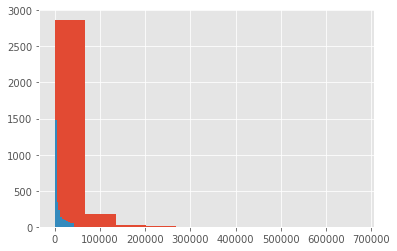

In [25]:
print('Паблик Putin')
print(f'Было стенок: {len(wall_putin)}')
text_len = [len(item['wall']) for item in wall_putin]
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.85)
wall_putin = [item['wall'] for item in wall_putin if len(item['wall']) < q]
print(f'Стало стенок после очистки: {len(wall_putin)}')
text_len = [len(item) for item in wall_putin]
plt.hist(text_len);

Для edinayarussia

Паблик EdinayaRussia
Было стенок: 3308
Стало стенок после очистки: 2811


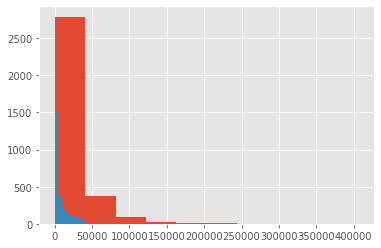

In [26]:
print('Паблик EdinayaRussia')
print(f'Было стенок: {len(wall_edinayarussia)}')
text_len = [len(item['wall']) for item in wall_edinayarussia]
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.85)
wall_edinayarussia = [item['wall'] for item in wall_edinayarussia if len(item['wall']) < q]
print(f'Стало стенок после очистки: {len(wall_edinayarussia)}')
text_len = [len(item) for item in wall_edinayarussia]
plt.hist(text_len);

Для medvedev

Паблик Medvedev
Было стенок: 1835
Стало стенок после очистки: 1559


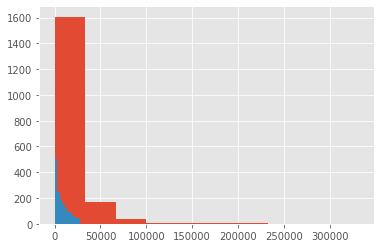

In [27]:
print('Паблик Medvedev')
print(f'Было стенок: {len(wall_medvedev)}')
text_len = [len(item['wall']) for item in wall_medvedev]
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.85)
wall_medvedev = [item['wall'] for item in wall_medvedev if len(item['wall']) < q]
print(f'Стало стенок после очистки: {len(wall_medvedev)}')
text_len = [len(item) for item in wall_medvedev]
plt.hist(text_len);

Для navalny

Паблик Navalny
Было стенок: 3102
Стало стенок после очистки: 2636


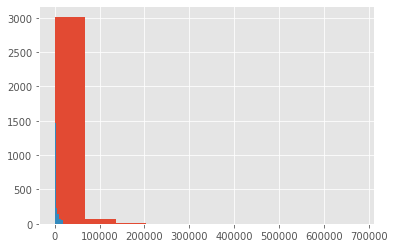

In [28]:
print('Паблик Navalny')
print(f'Было стенок: {len(wall_navalny)}')
text_len = [len(item['wall']) for item in wall_navalny]
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.85)
wall_navalny = [item['wall'] for item in wall_navalny if len(item['wall']) < q]
print(f'Стало стенок после очистки: {len(wall_navalny)}')
text_len = [len(item) for item in wall_navalny]
plt.hist(text_len);

Для varlamov

Паблик Varlamov
Было стенок: 1501
Стало стенок после очистки: 1275


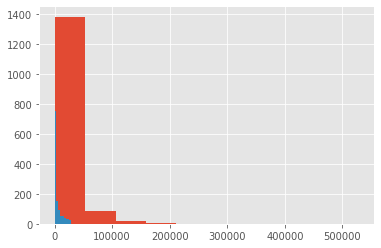

In [29]:
print('Паблик Varlamov')
print(f'Было стенок: {len(wall_varlamov)}')
text_len = [len(item['wall']) for item in wall_varlamov]
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.85)
wall_varlamov = [item['wall'] for item in wall_varlamov if len(item['wall']) < q]
print(f'Стало стенок после очистки: {len(wall_varlamov)}')
text_len = [len(item) for item in wall_varlamov]
plt.hist(text_len);

Для liberal

Паблик Liberal
Было стенок: 387
Стало стенок после очистки: 329


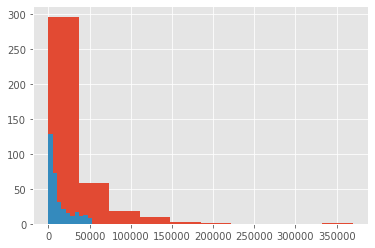

In [30]:
print('Паблик Liberal')
print(f'Было стенок: {len(wall_liberal)}')
text_len = [len(item['wall']) for item in wall_liberal]
plt.hist(text_len);

#Срежем тексты для удобной работы с ними
q = np.quantile(text_len, 0.85)
wall_liberal = [item['wall'] for item in wall_liberal if len(item['wall']) < q]
print(f'Стало стенок после очистки: {len(wall_liberal)}')
text_len = [len(item) for item in wall_liberal]
plt.hist(text_len);

In [31]:
#Удалим ненужные переменные
del text_len

In [37]:
print(f'Из группы Putin запарсилось {len(wall_putin)} хороших стен')
print(f'Из группы EdinayaRussia запарсилось {len(wall_edinayarussia)} хороших стен')
print(f'Из группы Medvedev запарсилось {len(wall_medvedev)} хороших стен')
print()
print(f'Из группы Navalny запарсилось {len(wall_navalny)} хороших стен')
print(f'Из группы Varlamov запарсилось {len(wall_varlamov)} хороших стен')
print(f'Из группы Liberal запарсилось {len(wall_liberal)} хороших стен')
print()
s = len(wall_putin) + len(wall_edinayarussia) + len(wall_medvedev) + len(wall_navalny) + len(wall_varlamov) + len(wall_liberal)
print(f'Всего стен: {s}')

Из группы Putin запарсилось 2624 хороших стен
Из группы EdinayaRussia запарсилось 2811 хороших стен
Из группы Medvedev запарсилось 1559 хороших стен

Из группы Navalny запарсилось 2636 хороших стен
Из группы Varlamov запарсилось 1275 хороших стен
Из группы Liberal запарсилось 329 хороших стен

Всего стен: 11234


Сохраним отобранные стены (на них будем проводить анализ)

In [33]:
with open('data/ParsingWall2/putin.pickle', 'wb') as f:
    pickle.dump(wall_putin, f)
    
with open('data/ParsingWall2/edinayarussia.pickle', 'wb') as f:
    pickle.dump(wall_edinayarussia, f)
    
with open('data/ParsingWall2/medvedev.pickle', 'wb') as f:
    pickle.dump(wall_medvedev, f)
    
with open('data/ParsingWall2/navalny.pickle', 'wb') as f:
    pickle.dump(wall_navalny, f)
    
with open('data/ParsingWall2/varlamov.pickle', 'wb') as f:
    pickle.dump(wall_varlamov, f)
    
with open('data/ParsingWall2/liberal.pickle', 'wb') as f:
    pickle.dump(wall_liberal, f)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Подгрузим наши данные (нужно длё того, если они повредились)

In [36]:
with open('data/ParsingWall2/putin.pickle', 'rb') as f:
    wall_putin = pickle.load(f)
    
with open('data/ParsingWall2/edinayarussia.pickle', 'rb') as f:
    wall_edinayarussia = pickle.load(f)
    
with open('data/ParsingWall2/medvedev.pickle', 'rb') as f:
    wall_medvedev = pickle.load(f)
    
with open('data/ParsingWall2/navalny.pickle', 'rb') as f:
    wall_navalny = pickle.load(f)
    
with open('data/ParsingWall2/varlamov.pickle', 'rb') as f:
    wall_varlamov = pickle.load(f)
    
with open('data/ParsingWall2/liberal.pickle', 'rb') as f:
    wall_liberal = pickle.load(f)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
#Почистим тексты стенок
m = Mystem(entire_input=False)

Installing mystem to C:\Users\student/.local/bin\mystem.exe from http://download.cdn.yandex.net/mystem/mystem-3.1-win-64bit.zip


In [ ]:
%%time
putin = [m.lemmatize(text) for text in wall_putin]

In [ ]:
%%time
edinayarussia = [m.lemmatize(text) for text in wall_edinayarussia]

In [ ]:
%%time
medvedev = [m.lemmatize(text) for text in wall_medvedev]

In [ ]:
%%time
navalny = [m.lemmatize(text) for text in wall_navalny]

In [ ]:
%%time
varlamov = [m.lemmatize(text) for text in wall_varlamov]

In [ ]:
%%time
liberal = [m.lemmatize(text) for text in wall_liberal]

In [ ]:
#Удалим ненужные переменные
del wall_putin
del wall_edinayarussia
del wall_medvedev
del wall_navalny
del wall_varlamov
del wall_liberal

Уберем из выборки такие слова, как 'и', 'а', 'но' и тд

In [62]:
stopwords_ru = stopwords.words('russian')

In [69]:
putin = [[word for word in text if word not in stopwords_ru and len(word) > 2] for text in putin]
edinayarussia = [[word for word in text if word not in stopwords_ru and len(word) > 2] for text in edinayarussia]
medvedev = [[word for word in text if word not in stopwords_ru and len(word) > 2] for text in medvedev]
navalny = [[word for word in text if word not in stopwords_ru and len(word) > 2] for text in navalny]
varlamov = [[word for word in text if word not in stopwords_ru and len(word) > 2] for text in varlamov]
liberal = [[word for word in text if word not in stopwords_ru and len(word) > 2] for text in liberal]

Возьмем нужное нам количество стен из всей выборки

In [92]:
putin = putin[:1000]
edinayarussia = edinayarussia[:1000]
medvedev = medvedev[:1000]
navalny = navalny[:1396]

Сохраним обработанные данные в data/ParsingWall3

Они выглядят вот так: wall = [[word1, word2, word3, ...], ...]

In [93]:
with open('data/ParsingWall3/putin.pickle', 'wb') as f:
    pickle.dump(putin, f)
    
with open('data/ParsingWall3/edinayarussia.pickle', 'wb') as f:
    pickle.dump(edinayarussia, f)
    
with open('data/ParsingWall3/medvedev.pickle', 'wb') as f:
    pickle.dump(medvedev, f)
    
with open('data/ParsingWall3/navalny.pickle', 'wb') as f:
    pickle.dump(navalny, f)
    
with open('data/ParsingWall3/varlamov.pickle', 'wb') as f:
    pickle.dump(varlamov, f)
    
with open('data/ParsingWall3/liberal.pickle', 'wb') as f:
    pickle.dump(liberal, f)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Подгрузим данные из файла (нужно для того если они повредились)

In [68]:
with open('data/ParsingWall3/putin.pickle', 'rb') as f:
    putin = pickle.load(f)
    
with open('data/ParsingWall3/edinayarussia.pickle', 'rb') as f:
    edinayarussia = pickle.load(f)
    
with open('data/ParsingWall3/medvedev.pickle', 'rb') as f:
    medvedev = pickle.load(f)
    
with open('data/ParsingWall3/navalny.pickle', 'rb') as f:
    navalny = pickle.load(f)
    
with open('data/ParsingWall3/varlamov.pickle', 'rb') as f:
    varlamov = pickle.load(f)
    
with open('data/ParsingWall3/liberal.pickle', 'rb') as f:
    liberal = pickle.load(f)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Часть 2 (Тематическая модель)
--

In [9]:
from gensim import corpora, models
from collections import defaultdict
import itertools 
from wordcloud import WordCloud 

Закинем все данные в один массив

In [60]:
k_power = len(putin) + len(edinayarussia) + len(medvedev)
k_opposition = len(navalny) + len(varlamov) + len(liberal)
data = putin + edinayarussia + medvedev + navalny + varlamov + liberal
group = ['power']*k_power + ['opposition']*k_opposition

In [61]:
#Удалим ненужные переменные
del putin
del edinayarussia
del medvedev
del navalny
del varlamov
del liberal

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [12]:
dictionary = corpora.Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]

corpus = [ [(0, кол-во поторений в выборке), (1, кол-во повт.), ...], ...]

Посмотрим, как часто какие слова встречаются в наших текстах 

In [13]:
def word_freq_plot(dictionary, corpus, k2=100, k1=0):
    
    '''Функция, которая строит график'''
    
    # Создаём по всем текстам словарик с частотами
    total_word_count = defaultdict(int)
    for word_id, word_count in itertools.chain.from_iterable(corpus):
        total_word_count[dictionary.get(word_id)] += word_count

    # Сортируем словарик по частотам
    sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)     
    
    # Делаем срез и по этому срезу строим картиночку 
    example_list = sorted_word_count[k1:k2]
    word = []
    frequency = []
    for i in range(len(example_list)):
        word.append(example_list[i][0])
        frequency.append(example_list[i][1])

    indices = np.arange(len(example_list))
    
    plt.figure(figsize=(22,10))
    plt.bar(indices, frequency)
    plt.xticks(indices, word, rotation='vertical',fontsize=12)
    plt.tight_layout()
    pass

Размер словаря до фильтрации: 208269


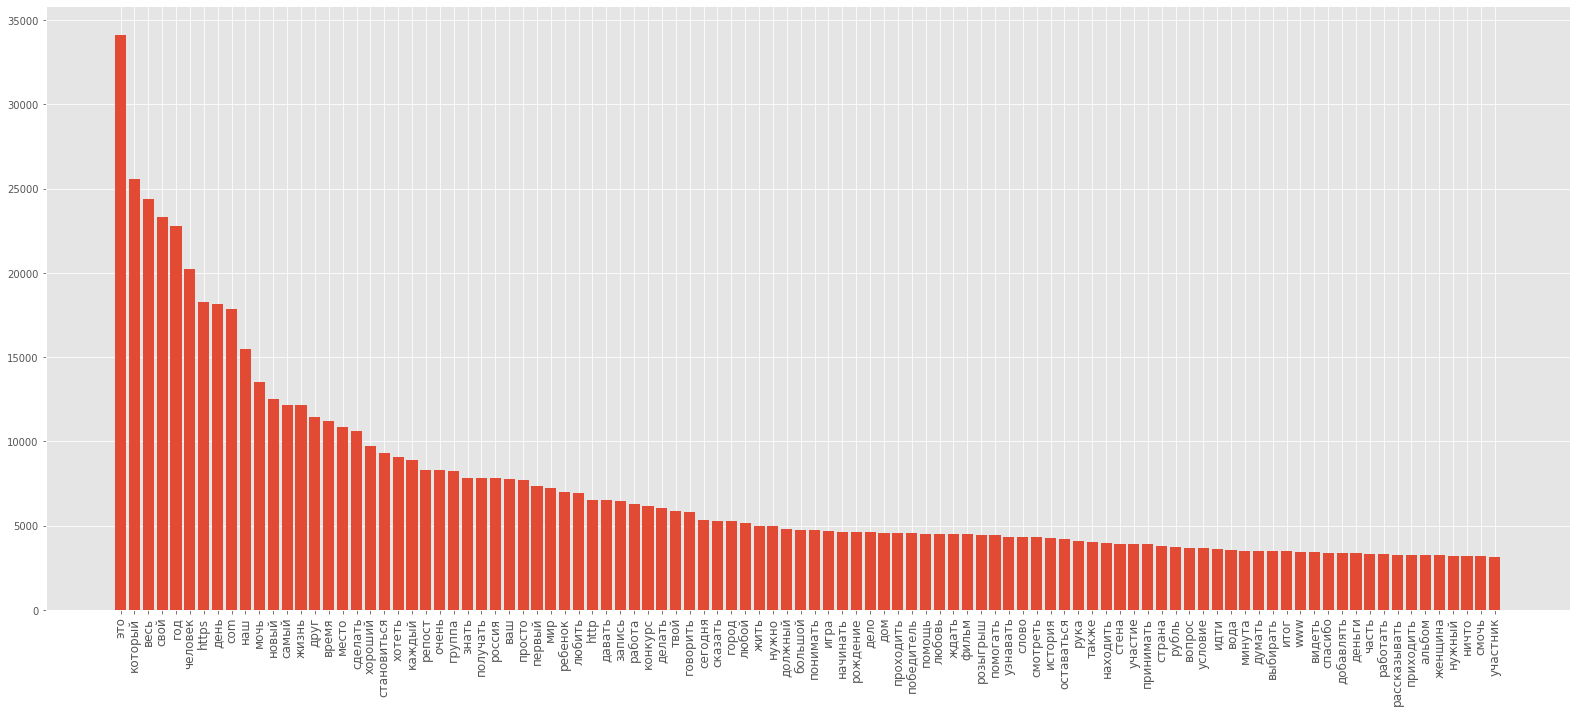

In [14]:
print(f'Размер словаря до фильтрации: {len(dictionary)}')
word_freq_plot(dictionary, corpus)

Так как слишком много шума в нашей выборке, нужно избавиться от стоп-слов

Отбросим слова, которые встречаются менее 10 раз и которые находятся более чем на 50 стенах

Размер словаря после фильтрации: 23128


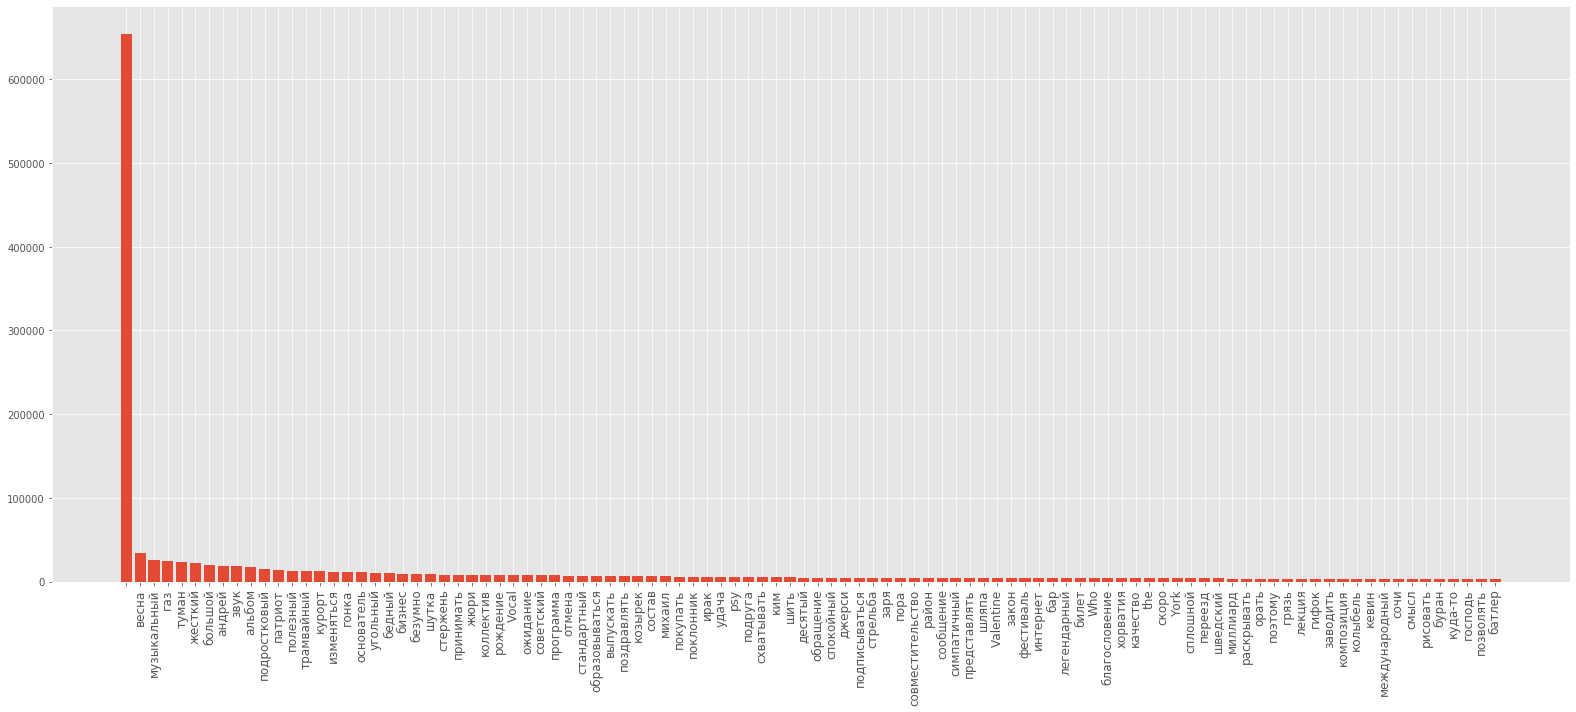

In [15]:
dictionary.filter_extremes(no_below=10, no_above=0.5)

print(f'Размер словаря после фильтрации: {len(dictionary)}')
word_freq_plot(dictionary, corpus)

Так же выбросим эти же слова из corpus

In [16]:
corpus = [dictionary.doc2bow(text) for text in data] 

Часть 3 (LDA модель)
--

In [11]:
%%time

T = 15 #Количество тематик

lda_model =  models.ldamulticore.LdaMulticore(corpus=corpus,       # корпус для обучения
                                             id2word=dictionary,   # словарь для обучения
                                             num_topics=T,         # число тематик, которые мы выделяем
                                             random_state=42,      # чтобы воспроизводилось при перезапуске
                                             passes=20)            # число проходов по коллекции документов 
                                                                   # (если долго работает, уменьшите его!)

Wall time: 3min 10s


Сохраним модель

In [12]:
!mkdir lda_model

In [13]:
lda_model.save('data/models/ldamodel')
np.save('data/models/explog', lda_model.expElogbeta)

Посмотрим для документа 7 распределение по темам

In [14]:
lda_model.get_document_topics(corpus[7])

[(3, 0.031370234),
 (7, 0.78603333),
 (8, 0.026778603),
 (9, 0.0360658),
 (13, 0.023300247),
 (14, 0.095553346)]

In [26]:
#А вот и сами темы
print('3 слово -', data[7][3]) #Для 3 слова
print('7 слово -', data[7][7]) #Для 7 слова
#И тд

3 слово - ностальгический
7 слово - город


Часть 4 (Интерпретация тематик)
--

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Загрузим модель (если ее переменная потеряла актуальность)

In [17]:
ldamodel = models.ldamodel.LdaModel.load('data/models/ldamodel')

expElogbeta = np.load('data/models/ldamodel.expElogbeta.npy')
ldamodel.expElogbeta = expElogbeta

T = ldamodel.num_topics # число тематик

------------------------------------------------------------------------------------------------------------------

In [19]:
topics = ldamodel.show_topics(num_topics=T, num_words=20, formatted=False)

In [20]:
for i,top in enumerate(topics):
    array = [item[0] for item in top[1]]
    print(f'{i} тема - {array}\n')

0 тема - ['ваш', 'работа', 'com', 'цена', 'сделать', 'работать', 'бизнес', 'время', 'получать', 'деньги', 'рубль', 'любой', 'компания', 'бесплатный', 'сайт', 'каждый', 'проект', 'вопрос', 'выбирать', 'хотеть']

1 тема - ['жизнь', 'любить', 'знать', 'хотеть', 'просто', 'друг', 'время', 'говорить', 'становиться', 'твой', 'каждый', 'хороший', 'сказать', 'ребенок', 'жить', 'понимать', 'любовь', 'очень', 'делать', 'давать']

2 тема - ['россия', 'страна', 'время', 'русский', 'путин', 'становиться', 'дело', 'город', 'первый', 'власть', 'война', 'российский', 'дом', 'народ', 'мир', 'москва', 'говорить', 'история', 'против', 'рубль']

3 тема - ['com', 'http', 'ряд', 'открытка', 'помогать', 'помощь', 'жизнь', 'нужный', 'получать', 'лицо', 'ali', 'петля', 'pub', 'ребенок', 'уровень', 'рука', 'проходить', 'интерн', 'смотреть', 'бонус']

4 тема - ['получать', 'друг', 'блять', 'нахуй', 'com', 'заходить', 'сука', 'рассказывать', 'ебать', 'твой', 'блядь', 'видеть', 'играть', 'бонус', 'рождение', 'хуй'

In [25]:
#Примерные темы набора слов
themes = {
    0: 'Заработок',
    1: 'Счастливая жизнь',
    2: 'Россия',
    3: 'Доброта',
    4: 'Современное общение друзей',
    5: 'Фильмы',
    6: 'Одиночество',
    7: 'Кулинария',
    8: 'Социальные сети',
    9: 'Область',
    10: 'Английские слова',
    11: 'Атомобильная тематика',
    12: 'Музыка',
    13: 'Конкурс в интернете',
    14: 'Торт'
}

Эта функция для каждой темы строит облака из слов

In [22]:
def getTopicWords(topic_number, lda_30_topics, scaling=10000):
    
    """Возвращает склеенные в текст слова топика, отмасштабированные по вероятности"""
    
    # забираем слова и вероятности из топиков
    topic = lda_30_topics[topic_number][1]
    # инициализируем пустой лист для хранения текста
    topic_multiplied = []
    # проходимся по всем словам топика
    for word, prob in topic:
        # повторяем слово N раз, где N = int(word_probability * scaling)
        topic_multiplied.append([word] * int(prob*scaling))
    
    # склеиваем все слова в один текст
    topic_multiplied = sum(topic_multiplied, [])
    topic_multiplied = ",".join(topic_multiplied)
    
    return topic_multiplied

Построим картинку на одну из тем

Заработок


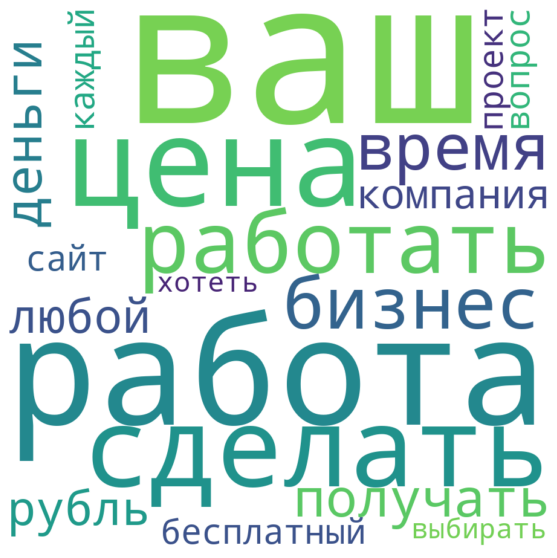

In [102]:
i = 0
wordcloud = WordCloud(background_color="white", max_words=2000, width=900, height=900, collocations=False)

print(themes[i])

wordcloud = wordcloud.generate(getTopicWords(i, topics, scaling=10000)) #Возьмем самую первую из тем

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

Теперь построим картинки по всем темам

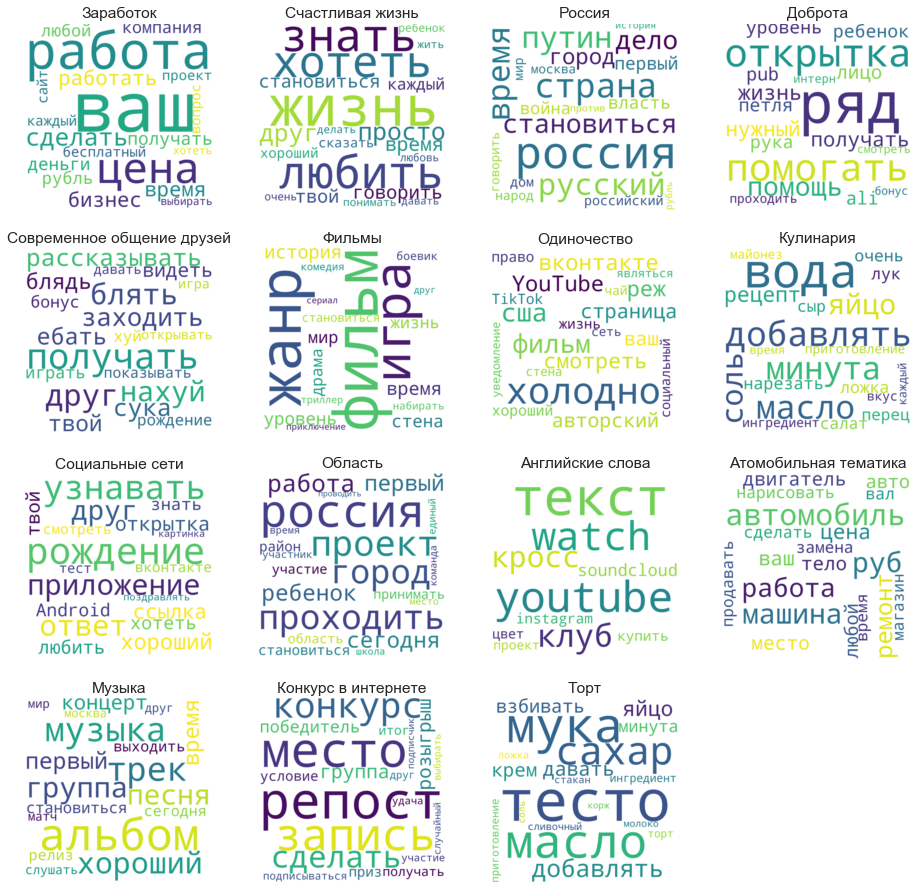

In [36]:
fig = plt.figure(figsize=(16, 20))
for i in range(T):
    ax = fig.add_subplot(5, 4, i+1)
    ax.grid(False)
    ax.axis('off')

    wordcloud = WordCloud(background_color="white", max_words=2000, width=900, height=900, collocations=False)
    wc = wordcloud.generate(getTopicWords(i, topics, scaling=10000))
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'{themes[i]}')
    
#Сохраним картинку
plt.savefig('data/Images/topics_of_words.png', dpi=450)

Найдем корреляцию между тематиками

In [37]:
# матрица тем
Phi = ldamodel.state.get_lambda()
print(Phi.shape)

S = pd.DataFrame(Phi.T).corr()

(15, 23128)


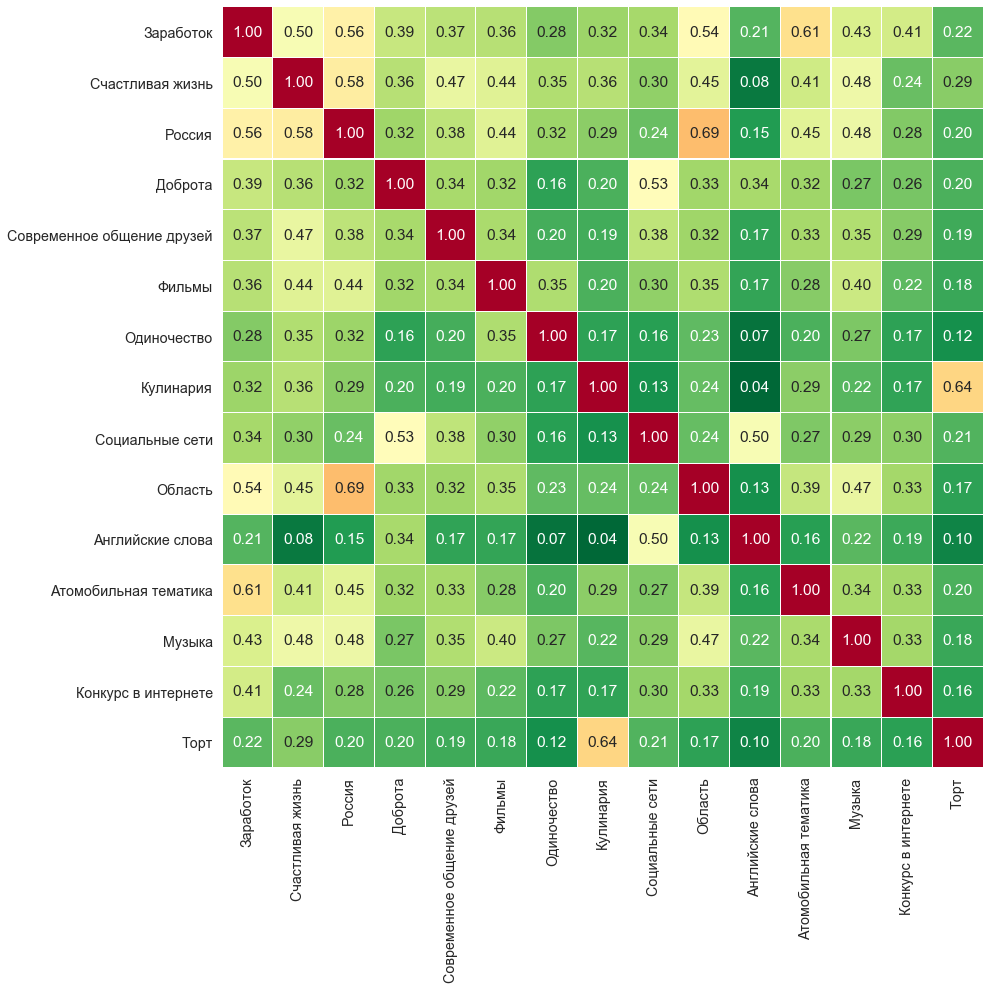

In [40]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(14, 14))
sns.heatmap(S, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=list(themes.values()), 
            xticklabels=list(themes.values()),
            cbar=False);

plt.savefig('data/Images/subject_correlation.png')

Построим визуализацию тематик

In [31]:
import pyLDAvis.gensim

In [32]:
%%time
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.036001  0.069688       1        1  25.858751
2     -0.030671  0.071054       2        1  14.785574
13    -0.038137 -0.046931       3        1   9.697487
9     -0.055522  0.033035       4        1   9.051821
12    -0.086095  0.012715       5        1   8.518164
7      0.235235 -0.050523       6        1   7.197104
5     -0.042404  0.103543       7        1   6.287302
0     -0.015812  0.005604       8        1   4.624441
8     -0.036676 -0.043991       9        1   3.566522
11     0.018909  0.007139      10        1   2.501405
14     0.224936 -0.103329      11        1   1.776138
3      0.004759 -0.012974      12        1   1.766092
10    -0.189427 -0.218127      13        1   1.707532
4     -0.007782  0.042727      14        1   1.425967
6     -0.017316  0.130371      15        1   1.235687, topic_info=     Category          Freq            Term         Total  loglift  logprob
14    Default  17447.000000             com  17447.000000  30.0000  30.0000
219   Default   8104.000000          репост   8104.000000  29.0000  29.0000
852   Default   6415.000000            http   6415.000000  28.0000  28.0000
331   Default   2624.000000             the   2624.000000  27.0000  27.0000
860   Default   3413.000000             www   3413.000000  26.0000  26.0000
225   Default   4512.000000        рождение   4512.000000  25.0000  25.0000
103   Default   6028.000000         конкурс   6028.000000  24.0000  24.0000
73    Default   6313.000000          запись   6313.000000  23.0000  23.0000
714   Default   4345.000000        розыгрыш   4345.000000  22.0000  22.0000
125   Default  10677.000000           место  10677.000000  21.0000  21.0000
61    Default  11367.000000            друг  11367.000000  20.0000  20.0000
186   Default   7766.000000        получать   7766.000000  19.0000  19.0000
796   Default   4260.000000        узнавать   4260.000000  18.0000  18.0000
1636  Default   4436.000000           фильм   4436.000000  17.0000  17.0000
175   Default   4422.000000      победитель   4422.000000  16.0000  16.0000
1267  Default  12201.000000           жизнь  12201.000000  15.0000  15.0000
773   Default   5852.000000            твой   5852.000000  14.0000  14.0000
1610  Default   1754.000000           текст   1754.000000  13.0000  13.0000
901   Default   3036.000000           ответ   3036.000000  12.0000  12.0000
664   Default   2891.000000      приложение   2891.000000  11.0000  11.0000
636   Default   4480.000000          помощь   4480.000000  10.0000  10.0000
911   Default   4438.000000        помогать   4438.000000   9.0000   9.0000
1249  Default   3316.000000       добавлять   3316.000000   8.0000   8.0000
231   Default  10546.000000         сделать  10546.000000   7.0000   7.0000
18    Default   3175.000000          альбом   3175.000000   6.0000   6.0000
291   Default   9699.000000         хороший   9699.000000   5.0000   5.0000
1350  Default   2197.000000           масло   2197.000000   4.0000   4.0000
122   Default   6950.000000          любить   6950.000000   3.0000   3.0000
53    Default   8107.000000          группа   8107.000000   2.0000   2.0000
1263  Default   2475.000000            жанр   2475.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
1116  Topic15    354.828552             сша   1530.637939   2.9317  -4.7155
1623  Topic15    116.330956     уведомление    329.216827   3.3533  -5.8307
1563  Topic15     66.039795     скопировать    143.382599   3.6183  -6.3969
870   Topic15    259.657318       вконтакте   1537.529175   2.6150  -5.0277
1432  Topic15     52.398483      письменный    107.526382   3.6747  -6.6282
6826  Topic15     96.956985  великобритания    322.142517   3.1928  -6.0128
1636  Topic15    360.655945           фильм   4436.295898   1.8839  -4.6992
1585  Topic15    157.064499      социальный   1163.624146   2.3909  -5.5305

Сохраним таблички с тематическими профилями

In [41]:
%%time
th_df = []  # матрица документы на темы 

for item in corpus:
    dct = dict(zip(range(T), [0]*T))
    dct.update(dict(ldamodel.get_document_topics(item)))
    th_df.append(dct)
    
th_df = pd.DataFrame(th_df)  

Wall time: 5.31 s


In [43]:
th_df.columns = list(themes.values())
th_df.shape

(6000, 15)

In [44]:
th_df.head()

,Заработок,Счастливая жизнь,Россия,Доброта,Современное общение друзей,Фильмы,Одиночество,Кулинария,Социальные сети,Область,Английские слова,Атомобильная тематика,Музыка,Конкурс в интернете,Торт
0,0.0,0.00000,0.078696,0.000000,0.0,0.000000,0.000000,0.018536,0.000000,0.440468,0.000000,0.026762,0.183876,0.250348,0.0
1,0.0,0.47914,0.000000,0.084281,0.0,0.000000,0.000000,0.000000,0.097134,0.000000,0.000000,0.313201,0.000000,0.021328,0.0
2,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.434777,0.000000,0.052335,0.000000,0.000000,0.509910,0.0
3,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.107634,0.000000,0.882003,0.000000,0.0
4,0.0,0.15153,0.000000,0.000000,0.0,0.029261,0.064108,0.000000,0.000000,0.093486,0.000000,0.000000,0.115535,0.533703,0.0


Самые часто-встречающиеся темы

In [46]:
from collections import Counter
top_th = Counter([themes[item] for item in th_df.get_values().argmax(axis=1)])
top_th.most_common()

[('Счастливая жизнь', 1778),
 ('Россия', 745),
 ('Музыка', 704),
 ('Конкурс в интернете', 698),
 ('Социальные сети', 513),
 ('Область', 298),
 ('Фильмы', 275),
 ('Заработок', 223),
 ('Кулинария', 196),
 ('Современное общение друзей', 152),
 ('Английские слова', 122),
 ('Атомобильная тематика', 108),
 ('Одиночество', 69),
 ('Доброта', 63),
 ('Торт', 56)]

Добавим группы

In [47]:
th_df['group'] = group
th_df.head()

,Заработок,Счастливая жизнь,Россия,Доброта,Современное общение друзей,Фильмы,Одиночество,Кулинария,Социальные сети,Область,Английские слова,Атомобильная тематика,Музыка,Конкурс в интернете,Торт,group
0,0.0,0.00000,0.078696,0.000000,0.0,0.000000,0.000000,0.018536,0.000000,0.440468,0.000000,0.026762,0.183876,0.250348,0.0,power
1,0.0,0.47914,0.000000,0.084281,0.0,0.000000,0.000000,0.000000,0.097134,0.000000,0.000000,0.313201,0.000000,0.021328,0.0,power
2,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.434777,0.000000,0.052335,0.000000,0.000000,0.509910,0.0,power
3,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.107634,0.000000,0.882003,0.000000,0.0,power
4,0.0,0.15153,0.000000,0.000000,0.0,0.029261,0.064108,0.000000,0.000000,0.093486,0.000000,0.000000,0.115535,0.533703,0.0,power


Не забудем сохранить)

In [49]:
th_df.to_csv('data/ThemesData/theme_data.tsv', sep='\t', index=False)

Часть 5 (Тематические профили изучаемых подписчиков)
--

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Подгрузим нашу табличку (нужно для того, если вдруг переменная повредилась)

In [51]:
th_df = pd.read_csv('data/ThemesData/theme_data.tsv', sep='\t')  # считали данные
th_df.head()

,Заработок,Счастливая жизнь,Россия,Доброта,Современное общение друзей,Фильмы,Одиночество,Кулинария,Социальные сети,Область,Английские слова,Атомобильная тематика,Музыка,Конкурс в интернете,Торт,group
0,0.0,0.00000,0.078696,0.000000,0.0,0.000000,0.000000,0.018536,0.000000,0.440468,0.000000,0.026762,0.183876,0.250348,0.0,power
1,0.0,0.47914,0.000000,0.084281,0.0,0.000000,0.000000,0.000000,0.097134,0.000000,0.000000,0.313201,0.000000,0.021328,0.0,power
2,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.434777,0.000000,0.052335,0.000000,0.000000,0.509910,0.0,power
3,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.107634,0.000000,0.882003,0.000000,0.0,power
4,0.0,0.15153,0.000000,0.000000,0.0,0.029261,0.064108,0.000000,0.000000,0.093486,0.000000,0.000000,0.115535,0.533703,0.0,power


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Сгруппируем подписчиков по темам и посмотрим на результат

In [53]:
groups_themes = th_df.groupby('group').mean()
groups_themes

,Заработок,Счастливая жизнь,Россия,Доброта,Современное общение друзей,Фильмы,Одиночество,Кулинария,Социальные сети,Область,Английские слова,Атомобильная тематика,Музыка,Конкурс в интернете,Торт
group,,,,,,,,,,,,,,,
opposition,0.041058,0.237957,0.147747,0.012111,0.042878,0.045774,0.015783,0.022615,0.072452,0.035027,0.031982,0.018555,0.130017,0.119399,0.008378
power,0.038223,0.270287,0.076872,0.019683,0.019067,0.058534,0.012288,0.047253,0.101676,0.076994,0.020475,0.028889,0.094565,0.107290,0.015638


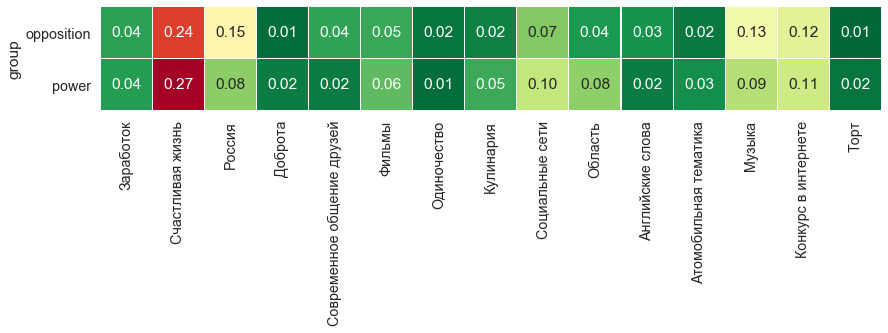

In [54]:
#Построим картинку
sns.set(font_scale=1.3)
plt.subplots(figsize=(14, 14))

sns.heatmap(groups_themes, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=list(groups_themes.index), 
            xticklabels=list(groups_themes.columns),
            cbar=False);
plt.savefig('data/Images/subscriber_topics.png')

Это у нас получилось вывести, чем различается аудитория системной власти и оппозиции. Теперь посмотрим на различия аудитории по группам. Подгрузим опять данные
--

In [69]:
k1 = len(putin)
k2 = len(edinayarussia)
k3 = len(medvedev)
k4 = len(navalny)
k5 = len(varlamov)
k6 = len(liberal)
group_names = ['putin']*k1 + ['edinayarussia']*k2 + ['medvedev']*k3 + ['navalny']*k4 + ['varlamov']*k5 + ['liberal']*k6

In [71]:
#Удалим ненужные переменные
del putin
del edinayarussia
del medvedev
del navalny
del varlamov
del liberal

In [72]:
#Подгрузим опять данные
th_df_names = pd.read_csv('data/ThemesData/theme_data.tsv', sep='\t')  # считали данные
th_df_names.head()

,Заработок,Счастливая жизнь,Россия,Доброта,Современное общение друзей,Фильмы,Одиночество,Кулинария,Социальные сети,Область,Английские слова,Атомобильная тематика,Музыка,Конкурс в интернете,Торт,group
0,0.0,0.00000,0.078696,0.000000,0.0,0.000000,0.000000,0.018536,0.000000,0.440468,0.000000,0.026762,0.183876,0.250348,0.0,power
1,0.0,0.47914,0.000000,0.084281,0.0,0.000000,0.000000,0.000000,0.097134,0.000000,0.000000,0.313201,0.000000,0.021328,0.0,power
2,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.434777,0.000000,0.052335,0.000000,0.000000,0.509910,0.0,power
3,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.107634,0.000000,0.882003,0.000000,0.0,power
4,0.0,0.15153,0.000000,0.000000,0.0,0.029261,0.064108,0.000000,0.000000,0.093486,0.000000,0.000000,0.115535,0.533703,0.0,power


In [73]:
th_df_names['public'] = group_names
th_df_names.head()

,Заработок,Счастливая жизнь,Россия,Доброта,Современное общение друзей,Фильмы,Одиночество,Кулинария,Социальные сети,Область,Английские слова,Атомобильная тематика,Музыка,Конкурс в интернете,Торт,group,public
0,0.0,0.00000,0.078696,0.000000,0.0,0.000000,0.000000,0.018536,0.000000,0.440468,0.000000,0.026762,0.183876,0.250348,0.0,power,putin
1,0.0,0.47914,0.000000,0.084281,0.0,0.000000,0.000000,0.000000,0.097134,0.000000,0.000000,0.313201,0.000000,0.021328,0.0,power,putin
2,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.434777,0.000000,0.052335,0.000000,0.000000,0.509910,0.0,power,putin
3,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.107634,0.000000,0.882003,0.000000,0.0,power,putin
4,0.0,0.15153,0.000000,0.000000,0.0,0.029261,0.064108,0.000000,0.000000,0.093486,0.000000,0.000000,0.115535,0.533703,0.0,power,putin


In [74]:
#Сохраним
th_df_names.to_csv('data/ThemesData/theme_data_with_publics.tsv', sep='\t', index=False)

Рассмотрим распределение тематик по пабликам

In [75]:
groups_themes_names = th_df_names.groupby('public').mean()
groups_themes_names

,Заработок,Счастливая жизнь,Россия,Доброта,Современное общение друзей,Фильмы,Одиночество,Кулинария,Социальные сети,Область,Английские слова,Атомобильная тематика,Музыка,Конкурс в интернете,Торт
public,,,,,,,,,,,,,,,
edinayarussia,0.046171,0.232382,0.087478,0.021090,0.013750,0.071401,0.008985,0.085171,0.129410,0.100170,0.013073,0.021267,0.041329,0.091211,0.023436
liberal,0.040611,0.292147,0.095383,0.017108,0.019198,0.057548,0.019950,0.035293,0.112845,0.030431,0.023644,0.032828,0.104264,0.083396,0.024018
medvedev,0.025008,0.298130,0.059682,0.013409,0.024207,0.054935,0.013535,0.018184,0.084313,0.033591,0.022874,0.041919,0.167744,0.120710,0.010917
navalny,0.029930,0.237531,0.159656,0.010561,0.050801,0.040214,0.016321,0.020272,0.070736,0.026925,0.030831,0.017108,0.116981,0.145943,0.006974
putin,0.043490,0.280348,0.083456,0.024550,0.019243,0.049268,0.014345,0.038404,0.091305,0.097220,0.025478,0.023480,0.074621,0.109948,0.012559
varlamov,0.053358,0.224441,0.148219,0.012519,0.040313,0.048824,0.014119,0.021909,0.063907,0.045085,0.035394,0.016457,0.150936,0.099627,0.005880


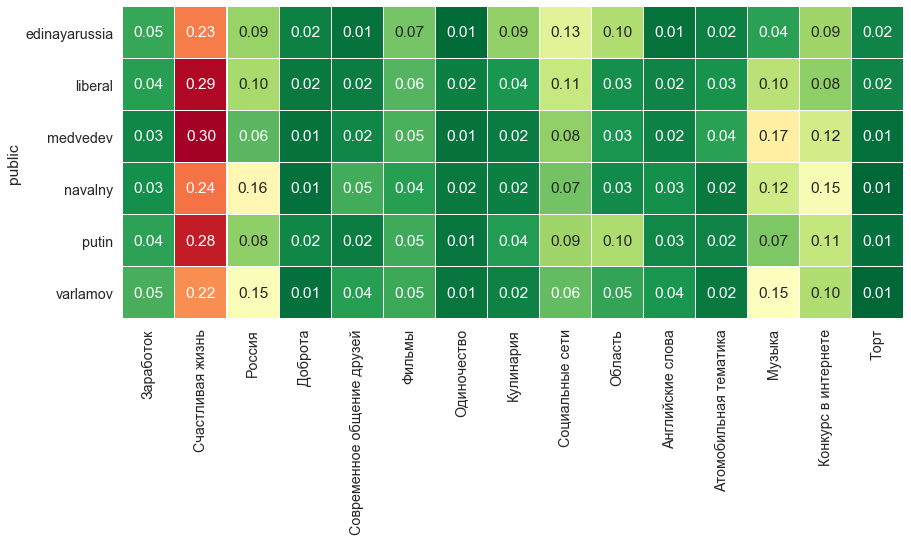

In [77]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(14, 14))

sns.heatmap(groups_themes_names, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=list(groups_themes_names.index), 
            xticklabels=list(groups_themes_names.columns),
            cbar=False);
plt.savefig('data/Images/Publics/subscriber_topics.png')

Теперь рассмотрим похожесть групп между собой

In [79]:
from scipy.spatial.distance import cosine

n = groups_themes_names.shape[0]  # выясняем число групп
R = np.zeros((n,n))         # заводим матрицу расстояний 


for i in range(n):
    vect1 = groups_themes_names.iloc[i]     # выделяем вектор для первого 
    for j in range(n):
        vect2 = groups_themes_names.iloc[j] # выделяем второй вектор 
        R[i,j] = cosine(vect1, vect2) # ищем косинусное расстояние

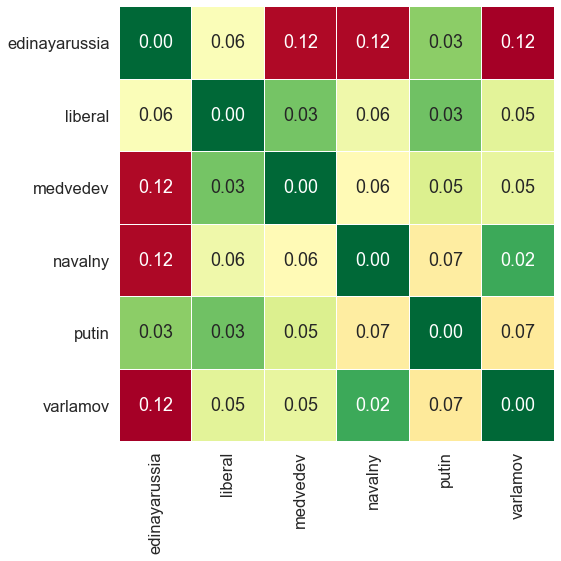

In [82]:
#Изобразим на графике
sns.set(font_scale=1.5)
plt.subplots(figsize=(8, 8))
sns.heatmap(R, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=list(groups_themes_names.index), 
            xticklabels=list(groups_themes_names.index), cbar=False);
plt.savefig('data/Images/Publics/similarity_of_public.png')

Часть 6 (Выводы)
--

In [95]:
from IPython.display import Image

Самые похожие темы оказались: Область и Россия (схожесть 69%). Самые непохожие - Кулинария и Английские слова (схожесть 4%). Впринципе по картинке схожести тем можно сделать вывод, что темы подобраны правильно, следовательно можно делать вывод, опираясь на них. (Пример: у темы Торт самая большая схожесть - Кулинария, логично, дальше, у темы Конкурс в интернете самая большая схожесть с темой Заработок, тут тоже нет логической ошибки и тд)

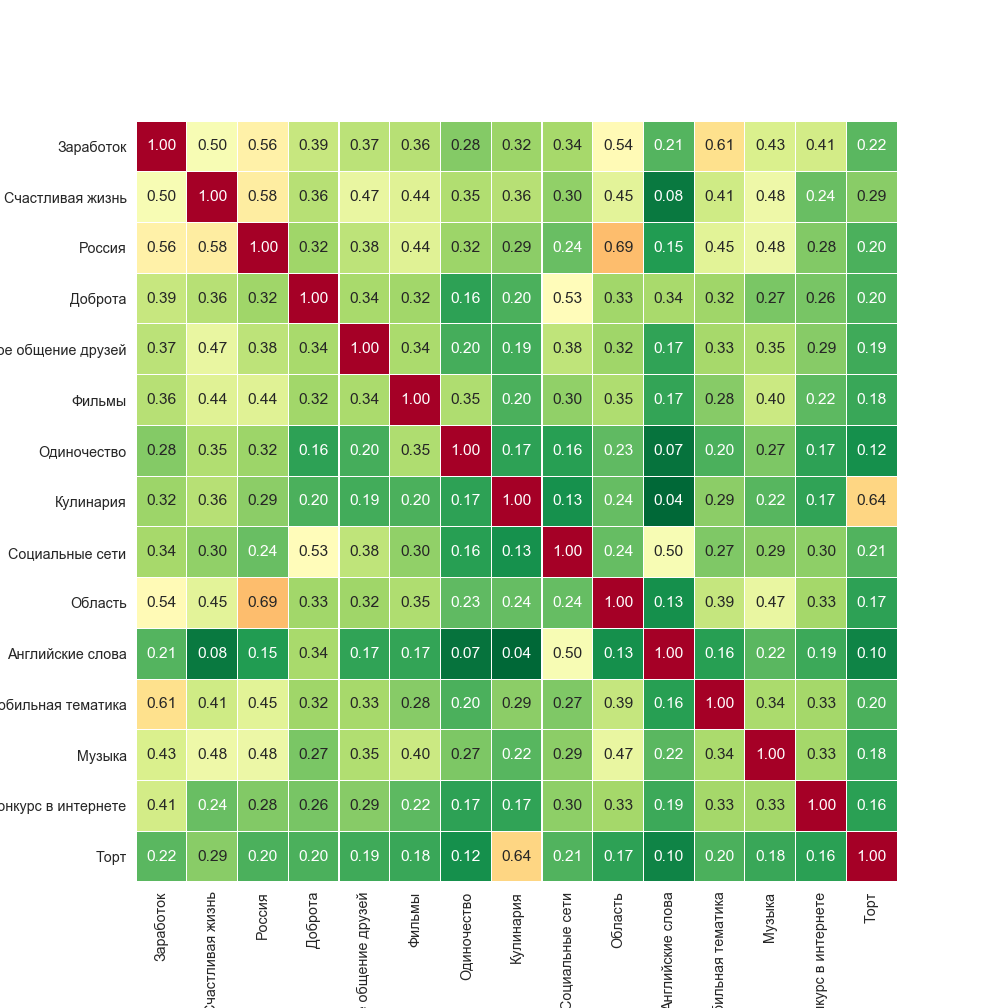

In [96]:
Image(filename='data/Images/subject_correlation.png')

Теперь передем к распределению тем между подписчиками Системной власти и Оппозиции. У обоих самой обсуждаемой темой является Счастливая жизнь (27% и 24% соответственно). У Оппозиции популярней в 2 раза тема Россия и тема Современное общение друзей (там, где мат), но при этом Власть в 2 раза больше интересуется темой Доброта. Следовательно, подписчики опозиии пишут чаще про Россию, но в основном, в негативном ключе (мы доказали очевидную вещь, опираясь на данные). Так же у Оппозиции тема Одиночество фигурирует в 2 раза больше, чем у подписчиков Системной власти. Теперь перейдем к странностям: подписчики Системной власти в 2 раза больше пишут про тему Область (в нашем представлении, тема Область должна была фигурировать больше у Оппозиции в негативном ключе, но это похоже миф). Так же подписчики власти интересуются слабее Оппозиции темой Музыка, но больше Кулинарией и Тортами (наверное это из-за различия в среднем возрасте этих 2-х групп). В принципе, это все самые интересные выводы, которые можно сделать исходя из этой картинки.

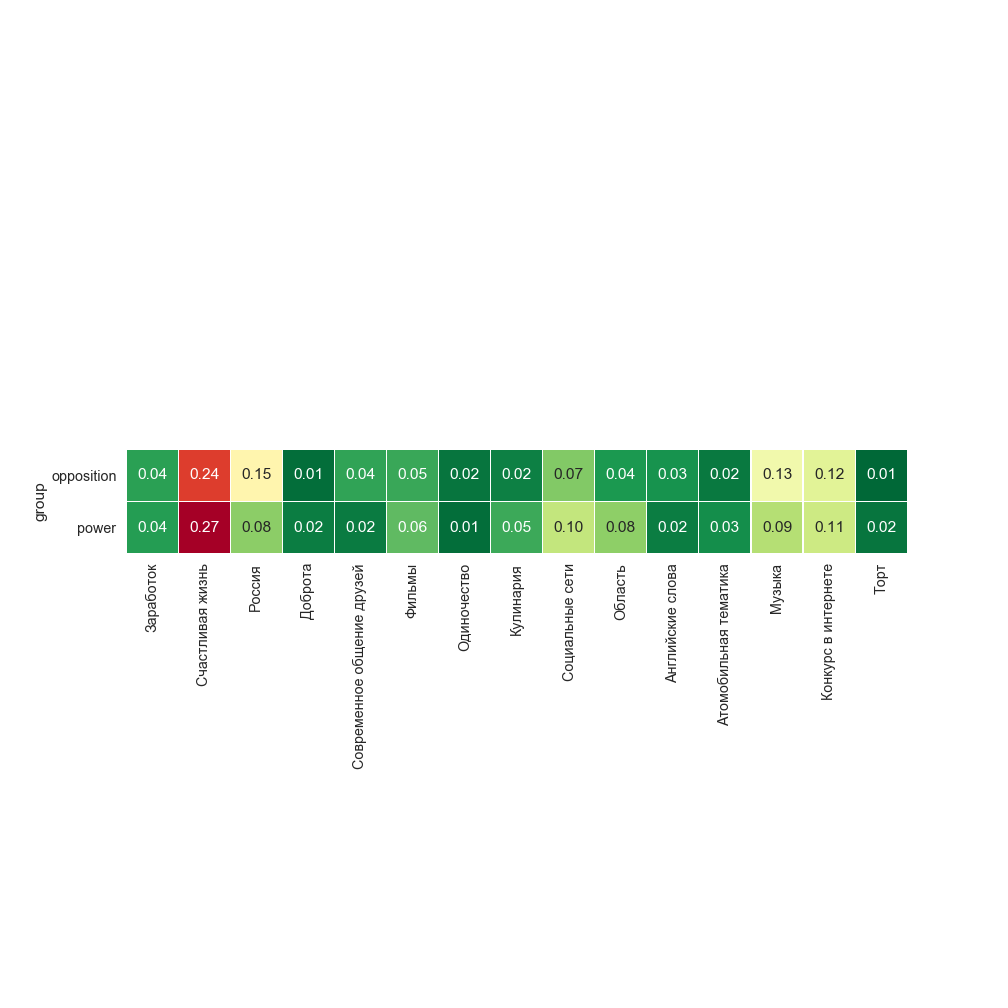

In [98]:
Image(filename='data/Images/subscriber_topics.png')

Теперь перейдем к более "низкому" изучению аудитории. Рассмотрим, как распределяются интересы между подписчиками пабликов.

Первая радостная новость: самая популярная тема у всех пабликов - Счастливая жизнь (даже не верится, что это российская аудитория). Теперь более подробно о каждом паблике.

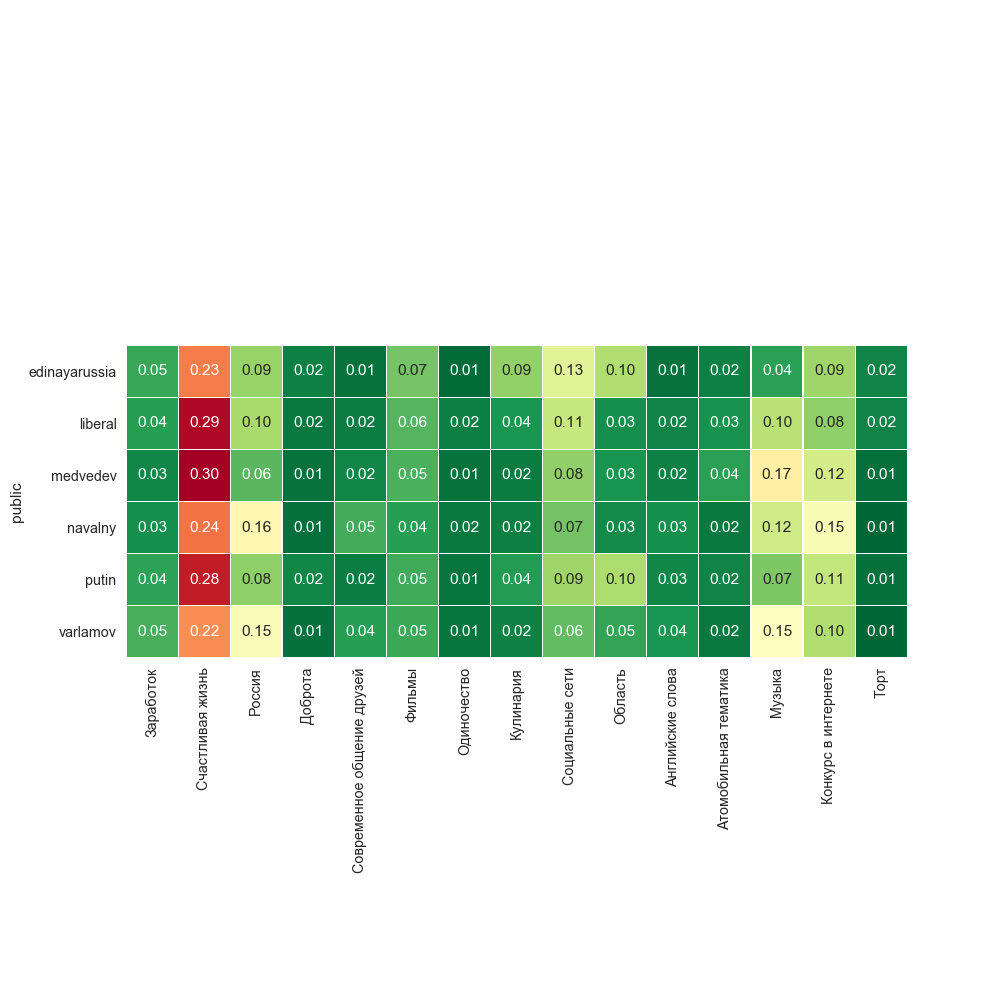

In [99]:
Image(filename='data/Images/Publics/subscriber_topics.png')

1) В паблике Единая Россия вторая по популярности тема - Социальные сети, 13% (слишком мало данных, чтобы сделать какой-то осмысленный вывод из этого). Самыми непопулярными темами оказались: Современное общение друзей (аудитория очень мало использует нецензурную брань), Одиночество и Английские слова. Это говорит о взрослой аудитории, которая не использует английские слова и радуется жизни. В общем, примерно мы так и представляли подписчиков паблика Единой России, так что каких-то шаблонов не разрушено (не считая загадки о теме Социальные сети, но слишком мало данных для объяснения такого вопроса).

2) В паблике Либерализм и Демократия второе по популярности место заняли аж 3 темы (с 10% интереса), вот они: Россия, Социальные сети и Музыка. Это говорит о том, что аудитория молодая (раз интересуется музыкой), так же она интересуется темой Россия (что радует). Самыми непопулярными темами оказались: Доброта, Кулинария, Одиночество и Английские слова. Наверное, доброта приходит с возрастом. Более молодое поколение не уделяет ей внимание. Неожиданно, что аудитория этого паблика так редко использует Английские слова (но с данными не поспоришь).

3) В паблике Медведев тема Счастливая жизнь популярнее, чем в остальных пабликах. На втором месте расположилась тема Музыка с 17% популярностью (аудитория часто слушает музыку). Это говорит не о слишком старой аудитории политика. Так же аудитория довольно часто интеерсуется темой Конкурсов (12%). Аудитория любит и верит в розыгрыши. Теперь передем к самым непопулярным темам: Доброта, Торт (1%). Так же аудитория редко матерится. Тут больше нет интересных выводов.

4) В паблике Навального популярны темы: Россия (16%) и Конкурсы в интернете (15%). Так же аудитория интеерсуется музыкой (12%). Мат популярен на 5%. Это говорит о довольно молодой и доверчивой (из-за конкурсов) аудитории. Самые непопулярные темы: Кулинария, Доброта, Автомобили и Торт.

5) В паблике Путин ситуация такая: Второй по популярности темой оказались Конкурсы (11%), Область (10%), Социальные сети (9%) и Россия (8%). Ничего аномального нет. Аудитория довольно доверчивая и интересуется Россией (так же областями). Тут похожая аудитория по тематике с пабликом Навальный, но с учетом того, что Музыка здесь популярна на 7% (у Навального на 12%). Конкурсами на 4% больше интересуются подписчики Навального, так же, как и темой Россия, но тут уже разница в 2 раза. Самыми непопулярными темами, так же, как и у Навального являются Одиночество, Доброта, Мат, Торт и Атомобили.

6) Последний паблик - Варламов. Помимо интереса к теме Счастливая жизнь, аудитории интересны темы Россия (15%) и Музыка (15%). Это говорит о молодой аудитории, которая интересуется Россией. Так же 10% интереса -Конкурсы в интернете. Тоже слишком много, как и у всех. Теперь передем к непопулярным вещам. Среди них: Доброта, Одиночество, Торт, Кулинария и Автомобили. В общем, так же, как и у остальных.

Теперь давайте посмотрим на схожесть аудиторий

Чем краснее ячейка, тем непохожие аудитории у групп. Самы непохожие аудитории у Медведева и Единой России (что странно), у Навального и Единой России, у Варламова и Единой России (мы опять доказали очевидное мнение, опираясь на данные). На втором месте непохожести аудитории у Путина с Навальным и Варламовым. Что так же является очевидной вещью. Самые похожие аудитории у Навального с Варламовым. Так же у Путина с Единой Россией, у Путина и Либералов (очень забавно) и у Медведева и Либералов. Тут статистика немного удивила. Что тут еще есть из интересного: у Навального аудитория отличается сильнее всего от других аудиторий (кроме Варламова). Так же у Путина и у Медведева аудитории различаются, что является странной вещью.

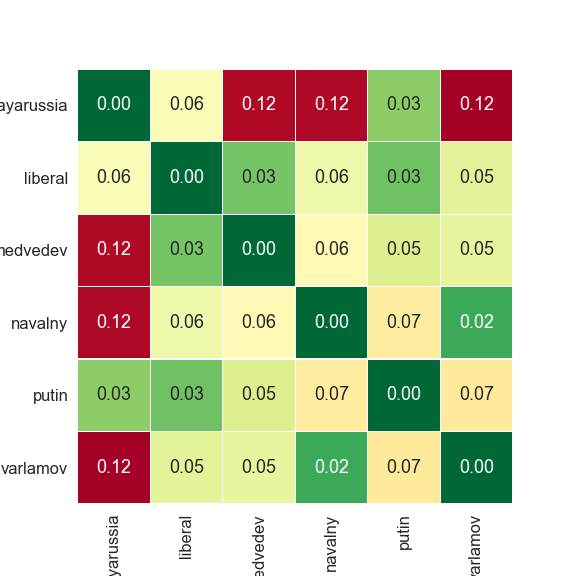

In [100]:
Image(filename='data/Images/Publics/similarity_of_public.png')

Вот такие выводы мы сделали из этих данных. Их было всего 6000 стен, что слишком мало. Возможно где-то мы ошиблись в выводах (из-за маленькой выборки), но в основных вещах ошибки не должно быть. 